# Chapter 5

In [50]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from theano import shared
# import sns

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
np.random.seed(0)

In [3]:
# Load data
data = pd.read_csv(os.path.join("Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

def unstandardize(std_series, original_series):
    """Given an input series restandardize"""
    unstandardize = std_series*original_series.std() + original_series.mean()
    return unstandardize

#### Code 5.1

In [6]:
# Standard regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [7]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [8]:
with pm.Model() as divorce_model_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5280.89draws/s]


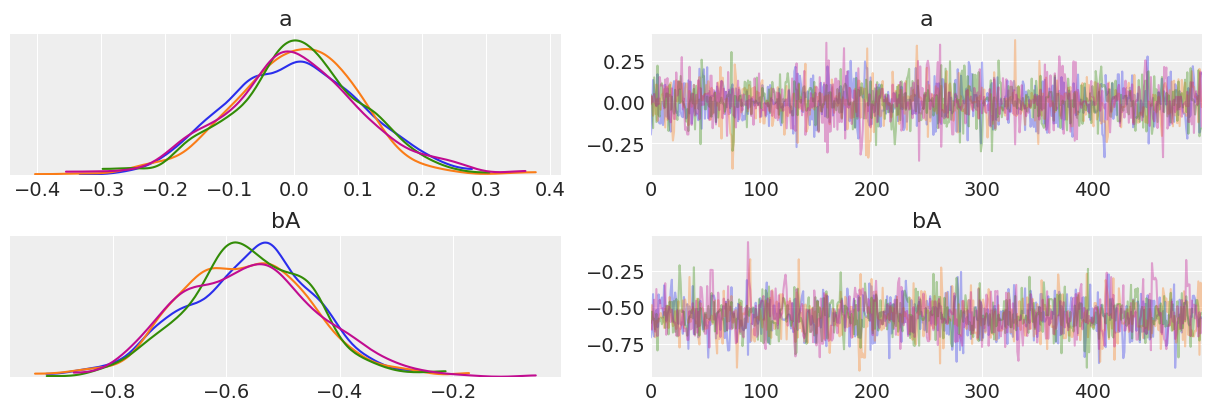

In [9]:
az.plot_trace(trace_divorce_age, var_names = ["a", "bA"]);

#### Code 5.4

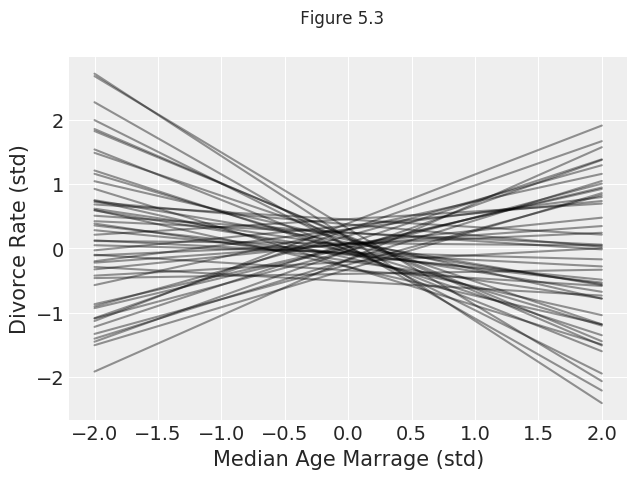

In [10]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:50], prior_samples["bA"][:50]):
    y = a + ba*x 
    ax.plot(x, y, c="black", alpha=.4)
    
ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle(" Figure 5.3");

#### Code 5.5

In [11]:
trace_divorce_age["bA"].shape

(2000,)

In [12]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_divorce_age_thinned = trace_divorce_age[::10]
mu_pred = np.zeros((len(age_std_seq), len(trace_divorce_age_thinned) * trace_divorce_age_thinned.nchains))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = trace_divorce_age_thinned["a"] + trace_divorce_age_thinned["bA"]*age_std

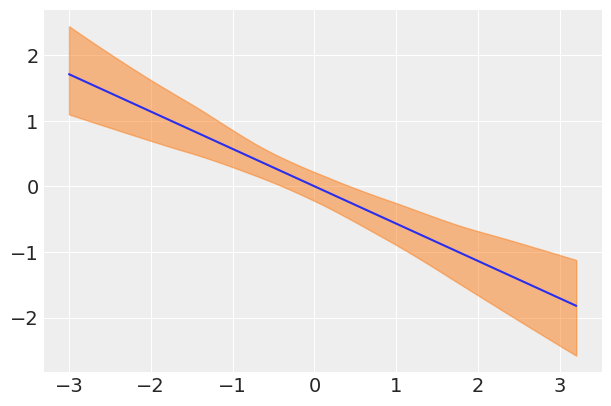

In [13]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)
plt.plot(age_std_seq, mu_mean)

# This is equivalent of Percent Interval
az.plot_hpd(age_std_seq, mu_pred.T);

#### 5.6

In [14]:
with pm.Model() as divorce_model_marriage:
    a = pm.Normal("a", 0, .2)
    bM = pm.Normal("bM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4928.33draws/s]


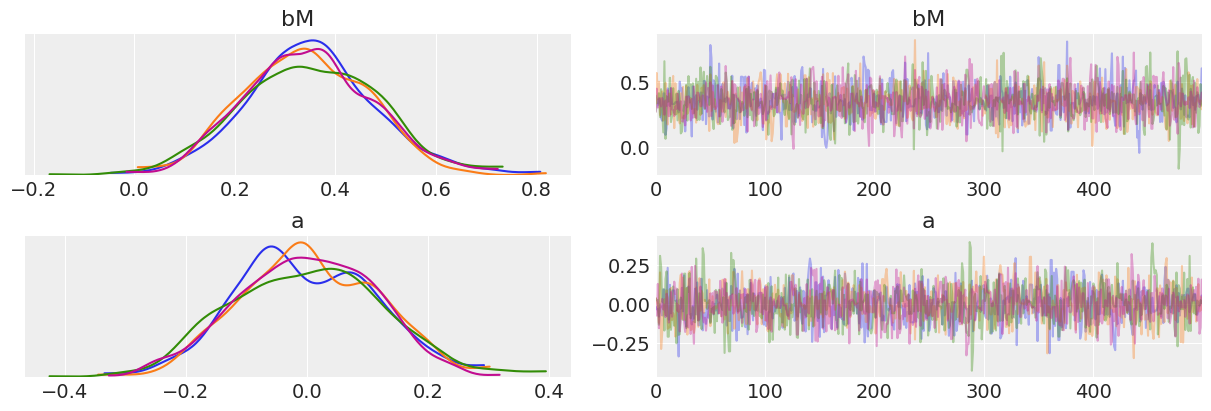

In [15]:
az.plot_trace(trace_divorce_marriage, var_names=["bM", "a"]);

#### 5.7

#### 5.8

#### 5.9

#### 5.13

In [16]:
with pm.Model() as divorce_model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a+bM*data["Marriage_std"] + bA*data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sd=sigma, observed = data["Divorce_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_divorce_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4098.37draws/s]


In [17]:
pm.summary(trace_divorce_marriage_age, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.100,-0.193,0.176,0.002,0.002,1763.0,1056.0,1774.0,1452.0,1.0
bM,-0.063,0.158,-0.367,0.229,0.004,0.004,1540.0,939.0,1538.0,1578.0,1.0
bA,-0.608,0.157,-0.904,-0.317,0.004,0.003,1522.0,1522.0,1529.0,1399.0,1.0
sigma,0.826,0.088,0.672,0.990,0.002,0.002,1600.0,1556.0,1653.0,1352.0,1.0


#### 5.11

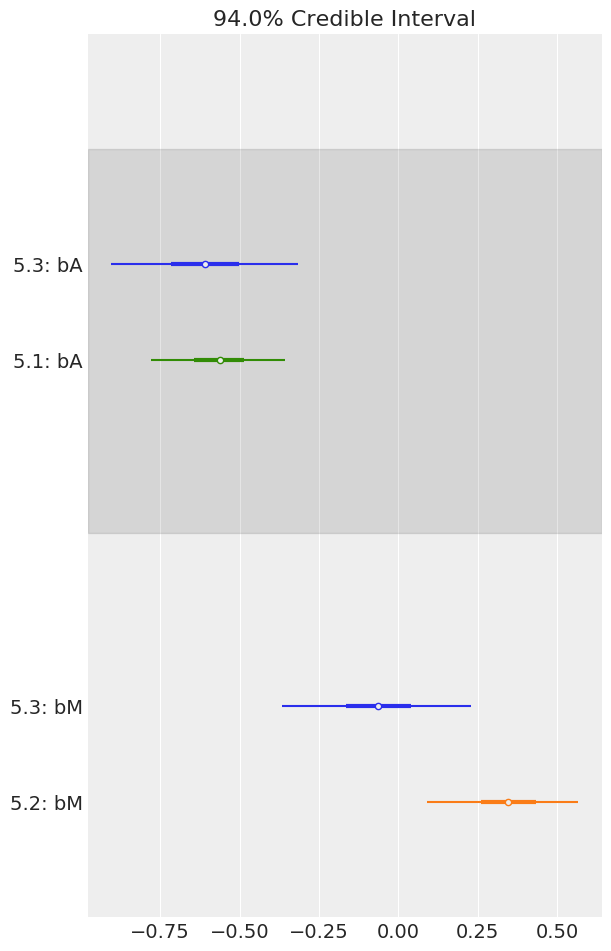

In [18]:
pm.plot_forest([trace_divorce_marriage_age, trace_divorce_marriage, trace_divorce_age,], model_names=["5.3", "5.2", "5.1"], var_names=["bA", "bM"], combined=True);

#### 5.12

In [19]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [20]:
 with pm.Model() as model_marriage_age:
    a = pm.Normal("a", 0, .2)
    bAM = pm.Normal("bAM", 0, .5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", a+bAM*data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal("_std", mu=mu, sd=sigma, observed = data["Marriage_std"].values)
    prior_samples = pm.sample_prior_predictive()
    trace_marriage_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bAM, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5045.36draws/s]


#### 5.14

In [21]:
mu_pred_marriage = trace_marriage_age["mu"].mean(axis=0)
residuals = data["Marriage_std"] - mu_pred_marriage_mean

NameError: name 'mu_pred_marriage_mean' is not defined

#### 5.15
Something is worng iwth tis plot

In [27]:
# Get mean of trace
mu_pred_divorce_marriage_age = trace_divorce_marriage_age["mu"].mean(axis=0)

In [28]:
# We can skip most of the code with the posterior predictive plot functionality in pymc3
with divorce_model_marriage_age:
    ppc_marriage_age = pm.sample_posterior_predictive(trace_divorce_marriage_age, samples=1000)

mean_posterior_predictive = ppc_marriage_age['divorce_rate_std'].mean(axis=0)

# percentiles = np.percentile(ppc_marriage_age['divorce_rate_std'], [5.5, 94.5], axis=1)
mu_hpd = az.hpd(ppc_marriage_age['divorce_rate_std'], credible_interval=0.89)

/home/canyon/miniconda3/lib/python3.7/site-packages/pymc3/sampling.py:1134: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 1337.47it/s]


#### 5.16

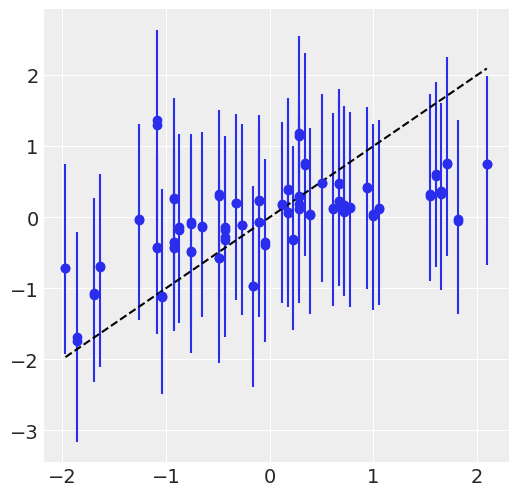

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(data["Divorce_std"].values, mu_pred_divorce_marriage_age)
plt.errorbar(data["Divorce_std"].values, mean_posterior_predictive, yerr=np.abs(mean_posterior_predictive - mu_hpd.T) , fmt='C0o')

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');


#### 5.18

In [30]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

NameError: name 'sns' is not defined

#### 5.19

In [47]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, .5)
    bM = pm.Normal("bM", 0, .5)

    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bA*data["MedianAgeMarriage_std"] + bM*data["Marriage_std"])
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])
    
    m5_3_A_divorce_trace = pm.sample()
    m5_3_A_divorce = pm.sample_posterior_predictive()

    
#     # A -> M
#     sigma_M = pm.Exponential("sigma_m", 1)
#     bAM = pm.Normal("bAM", 0, .5)
#     aM = pm.Normal("aM", 0, .2)
#     mu_M = pm.Deterministic("mu_m", aM + bAM*data["MedianAgeMarriage_std"])
#     marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])
    
#     m5_3_M_marriage = pm.sample()




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4261.73draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Wrong shape for initial_diag: expected 7 got 4

In [61]:
# Making this a shared variable lets us manipulate it later

median_marriage_age_shared = shared(data["MedianAgeMarriage_std"].values)
with pm.Model() as m5_3_A_M:
   
    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, .5)
    aM = pm.Normal("aM", 0, .2)
    mu_M = pm.Deterministic("mu_m", aM + bAM*median_marriage_age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])
    
    m5_3_M_marriage_trace = pm.sample()
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5158.51draws/s]


AttributeError: 'dict' object has no attribute '_straces'

#### 5.20

In [63]:
A_seq = np.linspace(-2, 2, 30)
A_seq.shape

(30,)

In [66]:
# Change the values to the sequence shape and simulate
median_marriage_age_shared.set_value(A_seq)
with m5_3_A_M:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_M_marriage_trace)
    
m5_3_M_marriage["marriage"].shape

100%|██████████| 2000/2000 [00:02<00:00, 715.84it/s]


(2000, 30)

## Extra code
Code that recreates some of the figures whos code isnt included in the book

In [ ]:
# Change domain of vars back to domain of original units
regular_age_seq = unstandardize(age_std_seq, data["MedianAgeMarriage"])
regular_divorce_seq = unstandardize(mu_mean, data["Divorce"])
regular_divorce_seq_pred = unstandardize(mu_pred, data["Divorce"])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(data["MedianAgeMarriage"], data["Divorce"], facecolors='none', edgecolors='b')
ax.set_yticks([13, 10, 6])
ax.set_xticks([23, 26, 29])
ax.plot(regular_age_seq, regular_divorce_seq)
az.plot_hpd(regular_age_seq, regular_divorce_seq_pred.T)